## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

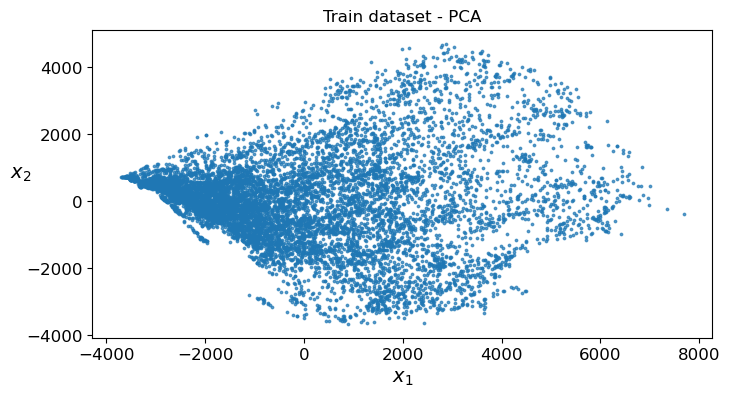

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca1)

Preprocessed the train dataset by winsorizing and normalising the data.

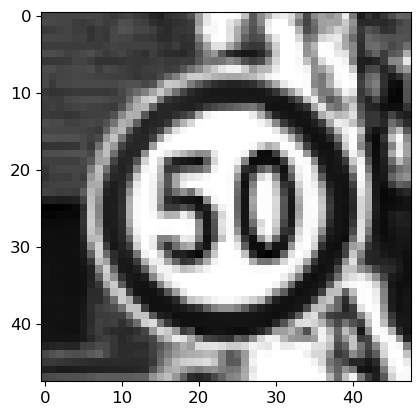

In [9]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

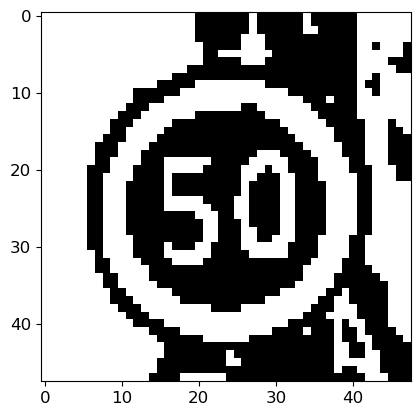

In [10]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [11]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
x_train = np.asarray(x_train)

In [15]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 50)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

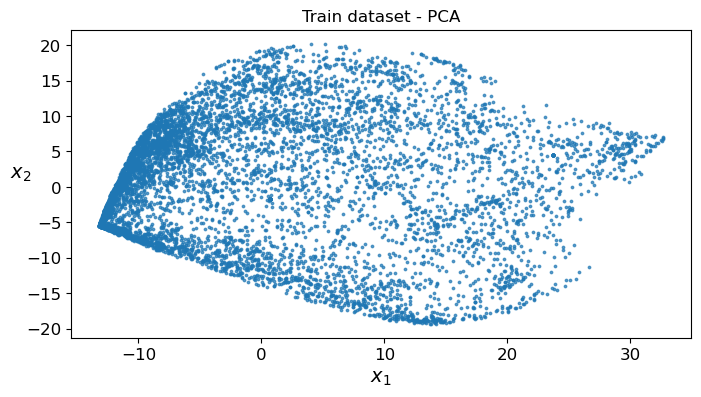

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

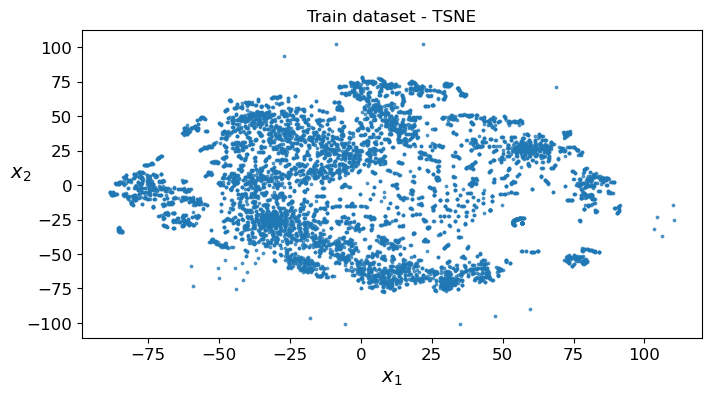

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

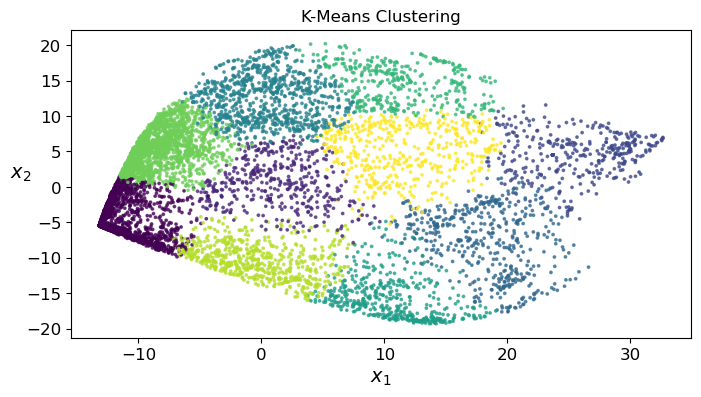

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [20]:
# from sklearn.metrics import accuracy_score

# y_train = np.asarray(y_train)

# cluster_to_majority_class = {}
# for cluster_label in np.unique(cluster_labels):
#     cluster_mask = (cluster_labels == cluster_label)
#     cluster_ground_truth_labels = y_train[cluster_mask].flatten()  # Flatten to 1D array
#     majority_class = np.bincount(cluster_ground_truth_labels).argmax()
#     cluster_to_majority_class[cluster_label] = majority_class

# # Assign majority class labels to all data points in each cluster
# cluster_assigned_labels = [cluster_to_majority_class[label] for label in cluster_labels]

# # Evaluate clustering accuracy
# accuracy = accuracy_score(y_train, cluster_assigned_labels)  # Compare with ground truth labels
# print(f"Clustering Accuracy: {accuracy}")

In [21]:
cluster_labels

array([1, 9, 1, ..., 8, 8, 8])

In [22]:
cluster_labels is kmeans.labels_

True

In [23]:
kmeans.inertia_

780451.9252441073

In [24]:
kmeans.cluster_centers_

array([[-2.84113128e+01, -9.58423551e+00],
       [ 2.75640969e+00, -2.46923950e+00],
       [ 6.56600985e+01,  1.19031912e+01],
       [ 4.73204480e+01, -1.90322835e+01],
       [-1.26182277e-02,  2.96561054e+01],
       [ 2.71548096e+01, -3.80281803e+01],
       [ 2.80876921e+01,  3.78820075e+01],
       [-2.17002315e+01,  1.10267997e+01],
       [-1.12760301e+00, -2.41673903e+01],
       [ 2.86890383e+01,  1.09005143e+01]])

In [25]:
kmeans.labels_

array([1, 9, 1, ..., 8, 8, 8])

In [26]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5507109002710854


In [27]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

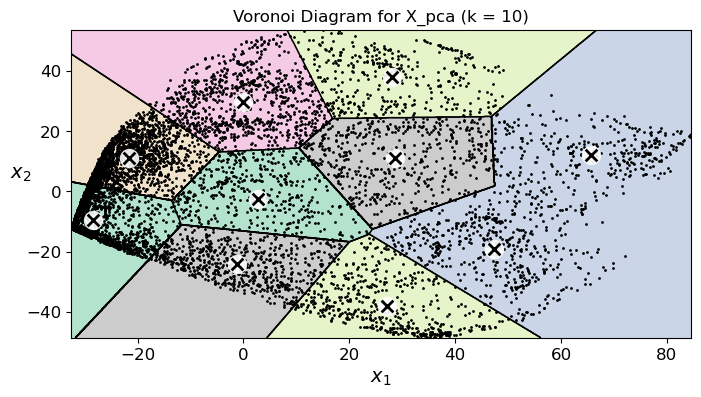

In [28]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

### 2) Hard & Soft Clustering

### 3) Determining Optimal Number of Clusters

In [29]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

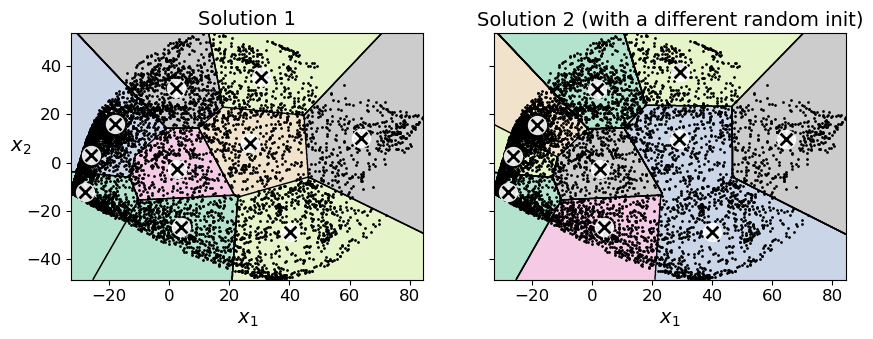

In [30]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

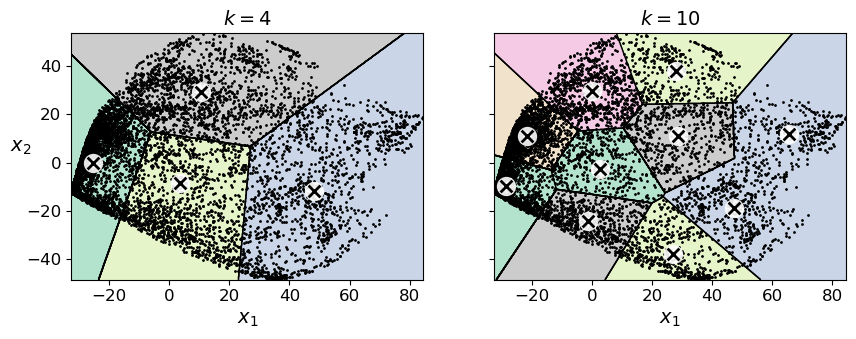

In [31]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [32]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

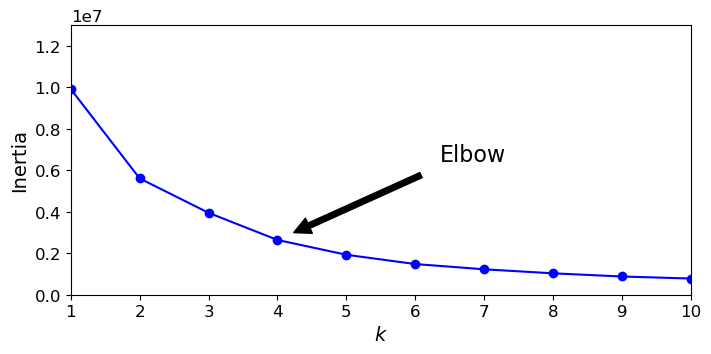

In [33]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 0, 13000000])  # Adjust the y-axis limit as needed
plt.show()


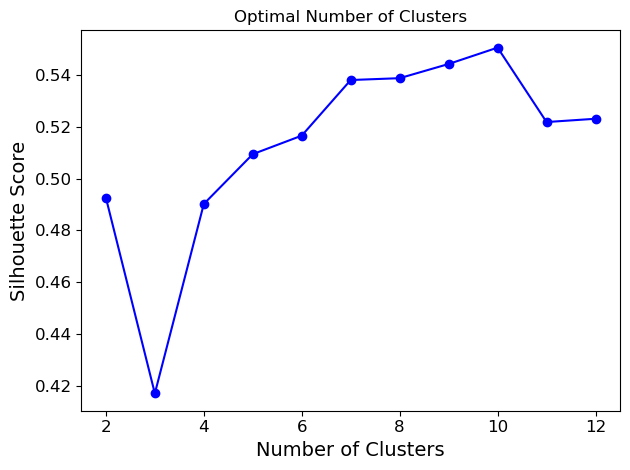

In [34]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

### DBSCAN Clustering (Hard Clustering)

To find the best value for epsilon, we first plot the K-distance graph

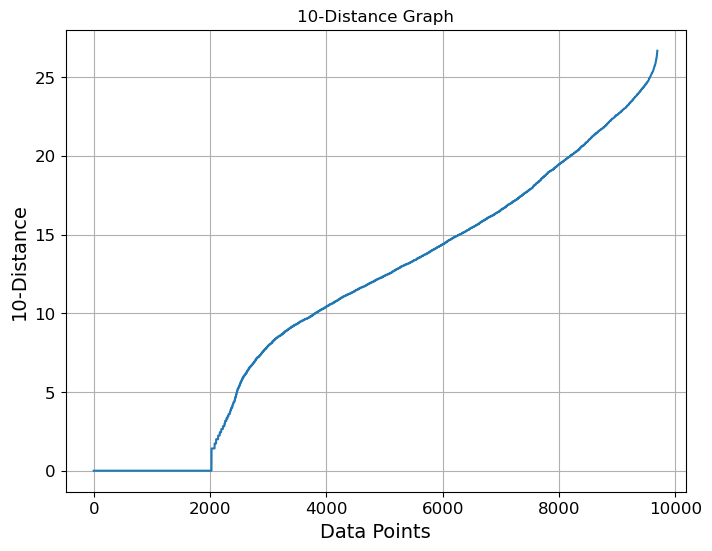

In [154]:
from sklearn.neighbors import NearestNeighbors

# Compute k-distances
k = 10 
nn = NearestNeighbors(n_neighbors=k)
nn.fit(x_train)
distances, _ = nn.kneighbors(x_train)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(range(len(x_train)), sorted_distances)
plt.xlabel("Data Points")
plt.ylabel(f"{k}-Distance")
plt.title(f"{k}-Distance Graph")
plt.grid()
plt.show()


In [195]:
from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=16, min_samples=180)  gives ss=32
# dbscan = DBSCAN(eps=17, min_samples=250)  gives ss=35
dbscan = DBSCAN(eps=16, min_samples=180) 
# nos 18, 180
dbscan.fit(x_train)

DBSCAN(eps=16, min_samples=180)

In [196]:
labels_dbscan = dbscan.labels_
labels_dbscan

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [197]:
unique_labels, counts = np.unique(labels_dbscan, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts = dict(zip(unique_labels, counts))

# Print the counts
for label, count in label_counts.items():
    if label == -1:
        print(f"Noise Points: {count} data points")
    else:
        print(f"Cluster {label}: {count} data points")

Noise Points: 4036 data points
Cluster 0: 5654 data points


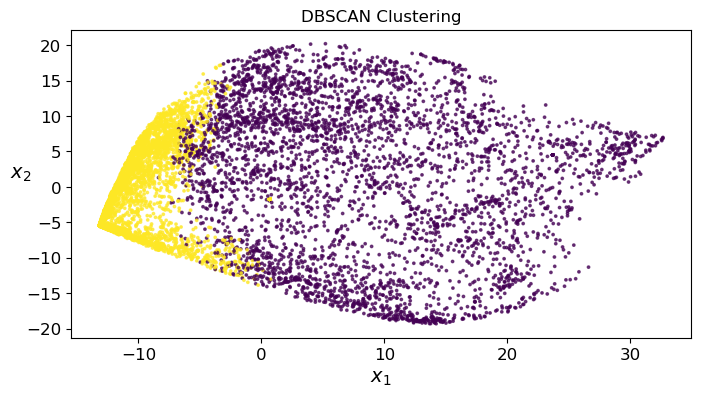

In [198]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_db = pca.fit_transform(x_train)

plot_figure("DBSCAN Clustering", X_pca_db, labels_dbscan)

In [199]:
from sklearn.metrics import silhouette_score

silhouette_scores_dbscan = silhouette_score(X_pca_db, labels_dbscan)
print("Silhouette Score = ", silhouette_scores_dbscan)

Silhouette Score =  0.3283288726640104


We tried playing around with the epsilon and min_sample values to try and get 10 clusters:

In [112]:
dbscan2 = DBSCAN(eps=16, min_samples=14)
dbscan2.fit(x_train)

DBSCAN(eps=16, min_samples=14)

In [113]:
labels_dbscan2 = dbscan2.labels_
labels_dbscan2

array([-1, -1, -1, ...,  0,  0, -1], dtype=int64)

In [114]:
unique_labels2, counts2 = np.unique(labels_dbscan2, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts2 = dict(zip(unique_labels2, counts2))

# Print the counts
for label2, count2 in label_counts2.items():
    if label == -1:
        print(f"Noise Points: {count2} data points")
    else:
        print(f"Cluster {label2}: {count2} data points")

Cluster -1: 2471 data points
Cluster 0: 6792 data points
Cluster 1: 26 data points
Cluster 2: 192 data points
Cluster 3: 27 data points
Cluster 4: 19 data points
Cluster 5: 18 data points
Cluster 6: 18 data points
Cluster 7: 26 data points
Cluster 8: 26 data points
Cluster 9: 75 data points


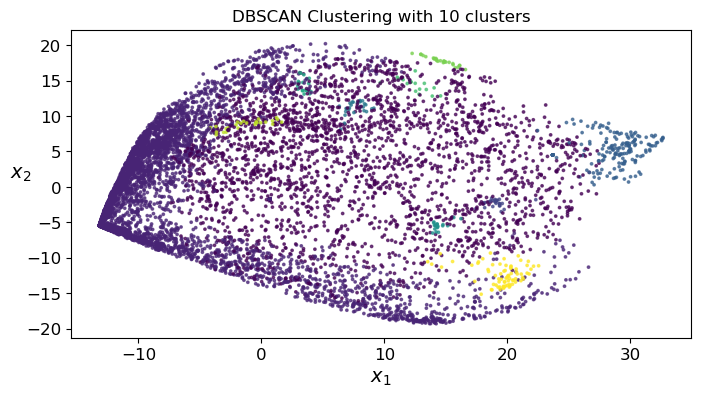

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_db2 = pca.fit_transform(x_train)

plot_figure("DBSCAN Clustering with 10 clusters", X_pca_db2, labels_dbscan2)

In [153]:
from sklearn.metrics import silhouette_score

silhouette_scores_dbscan2 = silhouette_score(X_pca_db2, labels_dbscan2)
print("Silhouette Score = ", silhouette_scores_dbscan2)

Silhouette Score =  -0.12547445881732988


### Fuzzy C Means Clustering (Soft Clustering)